In [1]:
import FinanceDataReader as fdr
import talib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import optuna
from tqdm import tqdm

c:\Users\User\AppData\Local\anaconda3\envs\jmc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 종목 및 구간 설정
ticker_symbol = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-07-02'

# 애플 주가 데이터 로드
data = fdr.DataReader(ticker_symbol, start=start_date, end=end_date)

# 컬럼 선택
selected_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
apple = data[selected_columns]

# 수정 종가 컬럼 종가로 이름 변경
apple = apple.rename(columns = {'Adj Close':'Close'})

print(apple.head())

                 Open       High        Low      Close     Volume
Date                                                             
2014-01-02  19.845715  19.893929  19.715000  17.273233  234684800
2014-01-03  19.745001  19.775000  19.301071  16.893808  392467600
2014-01-06  19.194643  19.528570  19.057142  16.985926  412610800
2014-01-07  19.440001  19.498571  19.211430  16.864449  317209200
2014-01-08  19.243214  19.484285  19.238930  16.971249  258529600


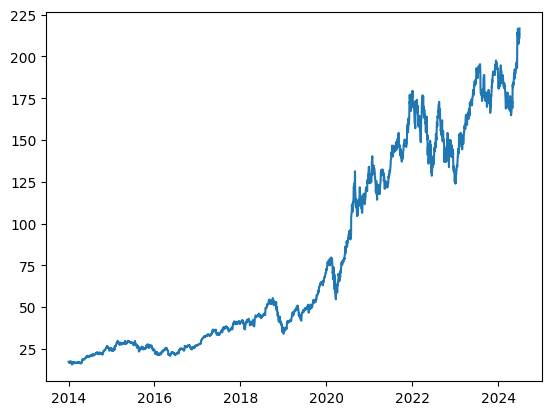

In [9]:
# 애플 수정종가 시각화
plt.plot(apple.index, apple["Close"])
plt.show()

In [10]:
# up down 컬럼 생성 (다음 날의 주가를 예측 하므로 하루씩 당겨서 생성)
apple['label'] = apple['Close'].shift(-1)
apple['label'] = apple.apply(lambda row: 'up' if row['label'] > row['Close'] else 'down', axis=1)

apple = apple[:-1]
apple

,Open,High,Low,Close,Volume,label
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,17.273233,234684800,down
2014-01-03,19.745001,19.775000,19.301071,16.893808,392467600,up
2014-01-06,19.194643,19.528570,19.057142,16.985926,412610800,down
2014-01-07,19.440001,19.498571,19.211430,16.864449,317209200,up
2014-01-08,19.243214,19.484285,19.238930,16.971249,258529600,down
...,...,...,...,...,...,...
2024-06-24,207.720001,212.699997,206.589996,208.139999,80727000,up
2024-06-25,209.149994,211.380005,208.610001,209.070007,56713900,up
2024-06-26,211.500000,214.860001,210.639999,213.250000,66213200,up


In [11]:
# 클래스 균형 확인
apple["label"].value_counts()

label
up      1397
down    1243
Name: count, dtype: int64

# TA-Lib

1. 수정종가 와 거래량 만을 사용하는 지표 사용
2. 값이 발산하거나 진동하지만 값이 극히 작아지거나 커지는 지표는 사용하지 않음
3. 파라미터는 디폴트값 사용

In [12]:
# 수정 종가와 거래량만 사용
close = apple['Close']
volume = apple["Volume"]

### CMO

In [ ]:
# Chande Momentum Oscillator를 계산하여 가격 변동의 모멘텀을 평가
help(talib.CMO)

Help on function CMO in module talib._ta_lib:

CMO(real, timeperiod=-2147483648)
    CMO(real[, timeperiod=?])
    
    Chande Momentum Oscillator (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 14
    Outputs:
        real



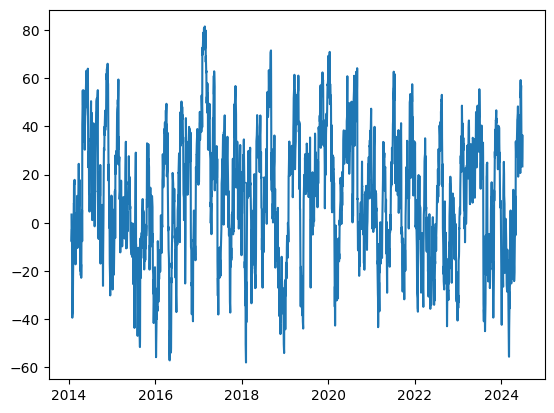

In [ ]:
# CMO 계산
cmo = talib.CMO(close, timeperiod=14)

# 시각화
plt.plot(cmo)
plt.show()

### HT_DCPERIOD

In [ ]:
# Hilbert Transform을 사용하여 지배적인 주기 기간을 계산하는 함수
help(talib.HT_DCPERIOD)

Help on function HT_DCPERIOD in module talib._ta_lib:

HT_DCPERIOD(real)
    HT_DCPERIOD(real)
    
    Hilbert Transform - Dominant Cycle Period (Cycle Indicators)
    
    Inputs:
        real: (any ndarray)
    Outputs:
        real



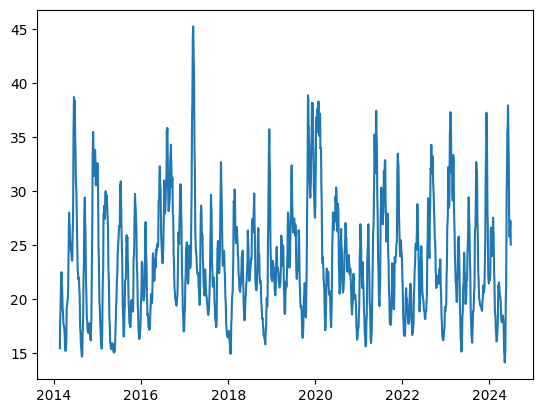

In [ ]:
# HT_DCPERIOD 계산
ht_dcperiod = talib.HT_DCPERIOD(close)

# 시각화
plt.plot(ht_dcperiod)
plt.show()

### HT_DCPHASE

In [ ]:
# Hilbert Transform을 사용하여 지배적인 사이클의 위상을 계산
help(talib.HT_DCPERIOD)

Help on function HT_DCPERIOD in module talib._ta_lib:

HT_DCPERIOD(real)
    HT_DCPERIOD(real)
    
    Hilbert Transform - Dominant Cycle Period (Cycle Indicators)
    
    Inputs:
        real: (any ndarray)
    Outputs:
        real



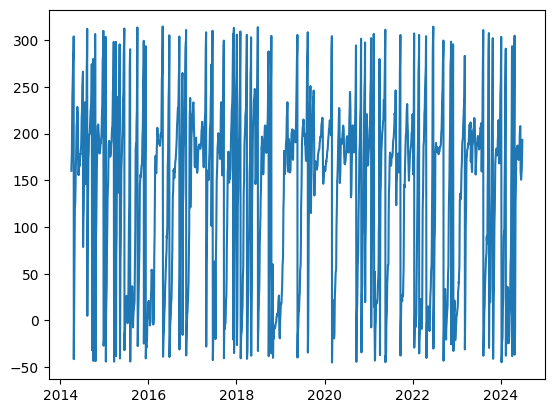

In [ ]:
# HT_DCPHASE 계산
ht_dcphase = talib.HT_DCPHASE(close)

# 시각화
plt.plot(ht_dcphase)
plt.show()

### HT_SINE

In [ ]:
# Hilbert Transform을 사용하여 지배적인 사이클의 사인 및 리드 값을 계산
help(talib.HT_SINE)

Help on function HT_SINE in module talib._ta_lib:

HT_SINE(real)
    HT_SINE(real)
    
    Hilbert Transform - SineWave (Cycle Indicators)
    
    Inputs:
        real: (any ndarray)
    Outputs:
        sine
        leadsine



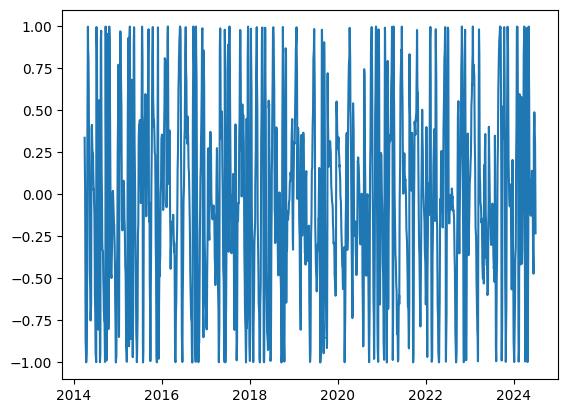

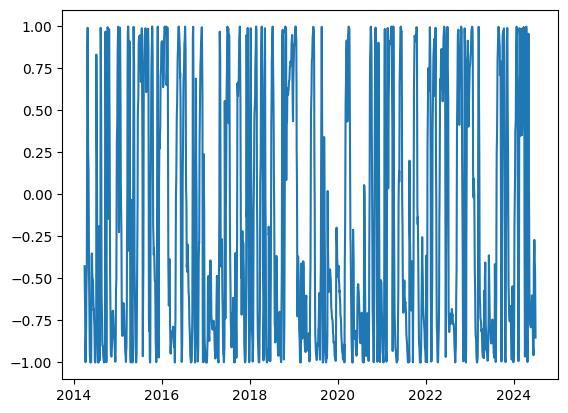

In [ ]:
# HT_SINE 계산
sine, leadsine = talib.HT_SINE(close)

# 시각화
for i in [sine, leadsine]:
    plt.plot(i)
    plt.show()

### HT_TRENDMODE

In [ ]:
# Hilbert Transform을 사용하여 현재 시장의 트렌드 모드를 결정 (0: 사이클 모드, 1: 트렌드 모드)
help(talib.HT_TRENDMODE)

Help on function HT_TRENDMODE in module talib._ta_lib:

HT_TRENDMODE(real)
    HT_TRENDMODE(real)
    
    Hilbert Transform - Trend vs Cycle Mode (Cycle Indicators)
    
    Inputs:
        real: (any ndarray)
    Outputs:
        integer (values are -100, 0 or 100)



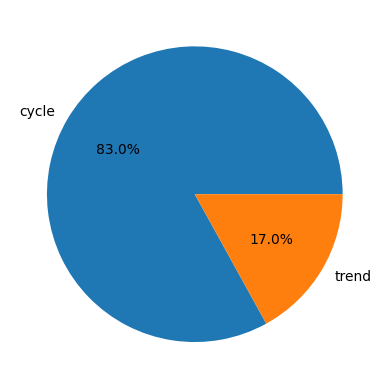

In [ ]:
# HT_TRENDMODE 계산 
ht_trendmode = talib.HT_TRENDMODE(close)

# 시각화
pi = ht_trendmode.value_counts()
plt.pie(pi, labels = ['cycle', 'trend'], autopct='%.1f%%')
plt.show()

### ppo

In [ ]:
# 두 이동 평균 간의 비율 차이
help(talib.PPO)

Help on function PPO in module talib._ta_lib:

PPO(real, fastperiod=-2147483648, slowperiod=-2147483648, matype=0)
    PPO(real[, fastperiod=?, slowperiod=?, matype=?])
    
    Percentage Price Oscillator (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        matype: 0 (Simple Moving Average)
    Outputs:
        real



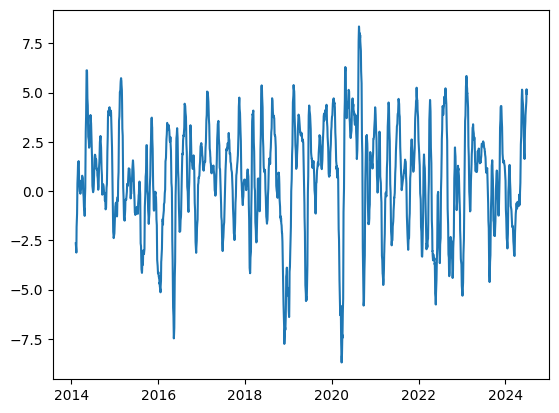

In [ ]:
# ppo 계산 
ppo = talib.PPO(close, fastperiod=12, slowperiod=26)

# 시각화
plt.plot(ppo)
plt.show()

### ROC

In [ ]:
# 기간 동안의 가격 변동률을 계산하여 가격 상승 또는 하락 속도를 평가
help(talib.ROC)

Help on function ROC in module talib._ta_lib:

ROC(real, timeperiod=-2147483648)
    ROC(real[, timeperiod=?])
    
    Rate of change : ((real/prevPrice)-1)*100 (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 10
    Outputs:
        real



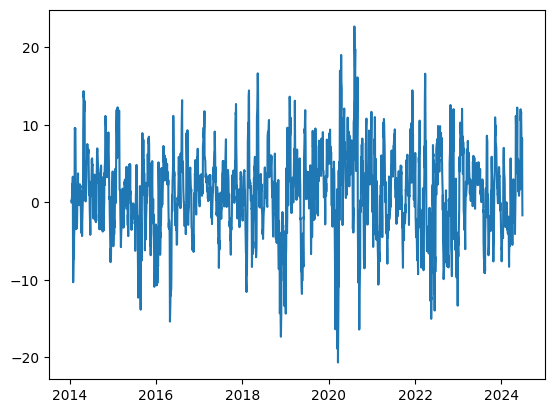

In [ ]:
# ROC 계산
roc = talib.ROC(close, timeperiod=10)

# 시각화
plt.plot(roc)
plt.show()

### RSI

In [ ]:
# 가격의 과매수 및 과매도 상태를 식별
help(talib.RSI)

Help on function RSI in module talib._ta_lib:

RSI(real, timeperiod=-2147483648)
    RSI(real[, timeperiod=?])
    
    Relative Strength Index (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 14
    Outputs:
        real



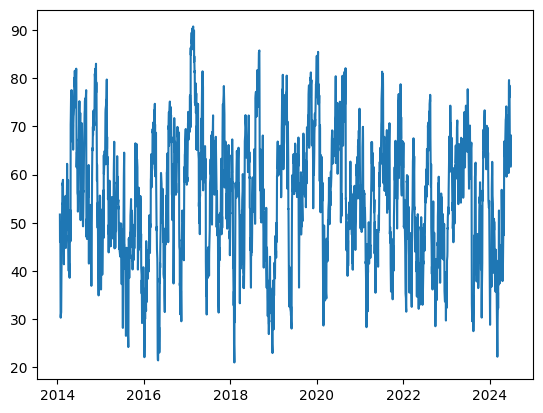

In [ ]:
# RSI 계산
rsi = talib.RSI(close, timeperiod=14)

# 시각화
plt.plot(rsi)
plt.show()

### STOCHRSI

In [ ]:
# 주어진 기간 동안의 스토캐스틱 RSI를 계산하여 RSI의 과매수 및 과매도 상태를 정밀하게 평가
help(talib.STOCHRSI)

Help on function STOCHRSI in module talib._ta_lib:

STOCHRSI(real, timeperiod=-2147483648, fastk_period=-2147483648, fastd_period=-2147483648, fastd_matype=0)
    STOCHRSI(real[, timeperiod=?, fastk_period=?, fastd_period=?, fastd_matype=?])
    
    Stochastic Relative Strength Index (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 14
        fastk_period: 5
        fastd_period: 3
        fastd_matype: 0
    Outputs:
        fastk
        fastd



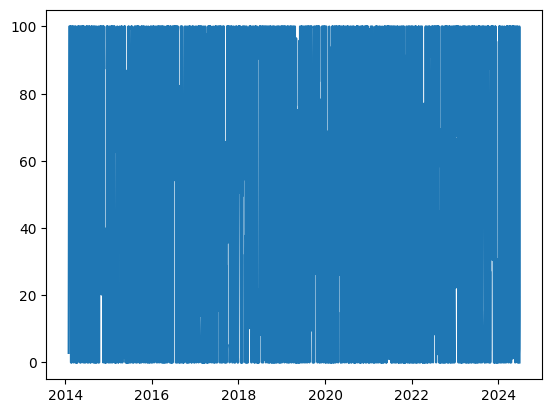

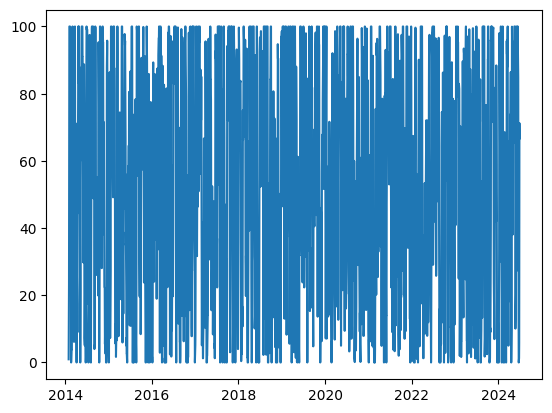

In [ ]:
# STOCHRSI 계산
fastk, fastd = talib.STOCHRSI(close,timeperiod=14, fastk_period=5, fastd_period=3)

# 시각화
for i in [fastk, fastd]:
    plt.plot(i)
    plt.show()

### TRIX

In [ ]:
# 주어진 기간 동안의 세 번의 지수 이동 평균을 사용하여 TRIX 값을 계산
help(talib.TRIX)

Help on function TRIX in module talib._ta_lib:

TRIX(real, timeperiod=-2147483648)
    TRIX(real[, timeperiod=?])
    
    1-day Rate-Of-Change (ROC) of a Triple Smooth EMA (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 30
    Outputs:
        real



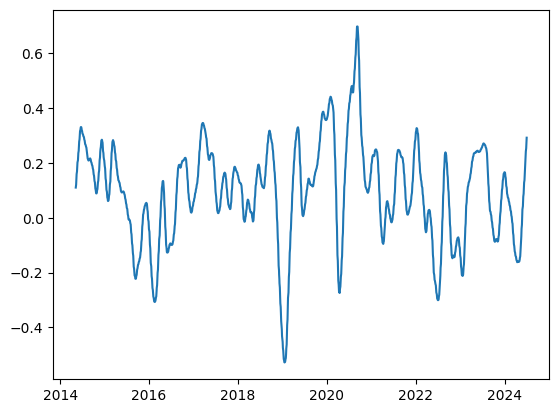

In [ ]:
# TRIX 계산
trix = talib.TRIX(close, timeperiod=30)

# 시각화
plt.plot(trix)
plt.show()

## 분류 모델 구축을 위한 데이터 프레임 생성(기술적 지표만 사용)

In [13]:
apple.loc[:, 'cmo'] = talib.CMO(close, timeperiod=14)
apple.loc[:, 'ht_dcperiod'] = talib.HT_DCPERIOD(close)
apple.loc[:, 'ht_dcphase'] = talib.HT_DCPHASE(close)
sine, leadsine = talib.HT_SINE(close)
apple.loc[:, 'sine'] = sine
apple.loc[:, 'leadsine'] = leadsine
apple.loc[:, 'ht_trendmode'] = talib.HT_TRENDMODE(close)
apple.loc[:, 'ppo'] = talib.PPO(close, fastperiod=12, slowperiod=26)
apple.loc[:, 'roc'] = talib.ROC(close, timeperiod=10)
apple.loc[:, 'rsi'] = talib.RSI(close, timeperiod=14)
fastk, fastd = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3)
apple.loc[:, 'fastk'] = fastk
apple.loc[:, 'fastd'] = fastd
apple.loc[:, 'trix'] = talib.TRIX(close, timeperiod=30)

In [14]:
# 특정 날짜 이전의 행 삭제
cutoff_date = pd.Timestamp('2014-06-02')
apple = apple[apple.index >= cutoff_date]

In [15]:
# 결측치 확인
apple.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
label           0
cmo             0
ht_dcperiod     0
ht_dcphase      0
sine            0
leadsine        0
ht_trendmode    0
ppo             0
roc             0
rsi             0
fastk           0
fastd           0
trix            0
dtype: int64

In [16]:
# 결과를 CSV 파일로 저장
apple.to_csv('apple_TI.csv')

# 분류 모델 구축

In [17]:
df = pd.read_csv("apple_TI.csv", index_col='Date')

In [18]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'label', 'cmo', 'ht_dcperiod',
       'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi',
       'fastk', 'fastd', 'trix'],
      dtype='object')

## 상관관계 변수 선택

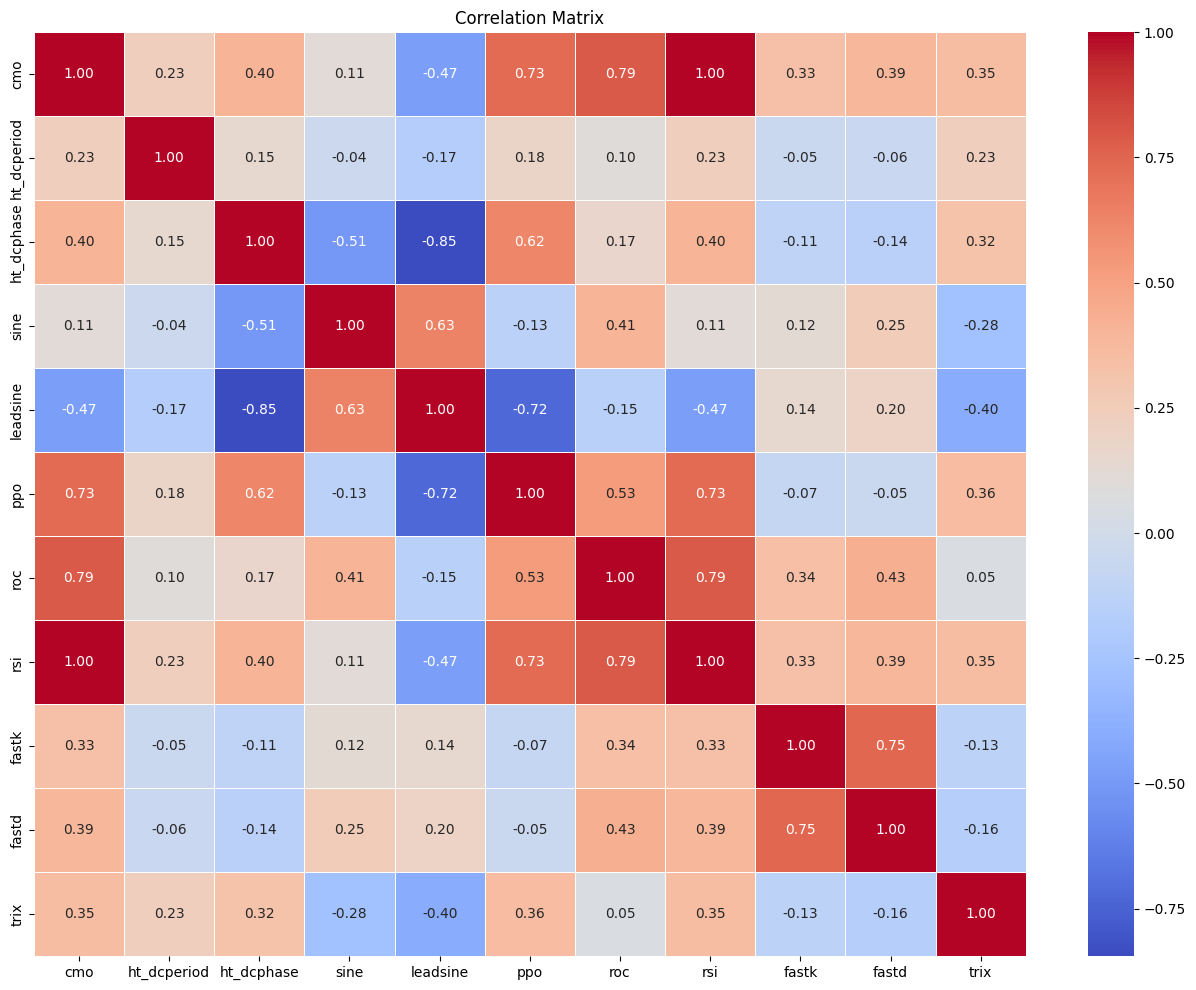

In [19]:
# 상관관계 그래프
heatmap = df.copy()

select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

hm = heatmap[select]

# 상관관계 행렬 계산
corr = hm.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

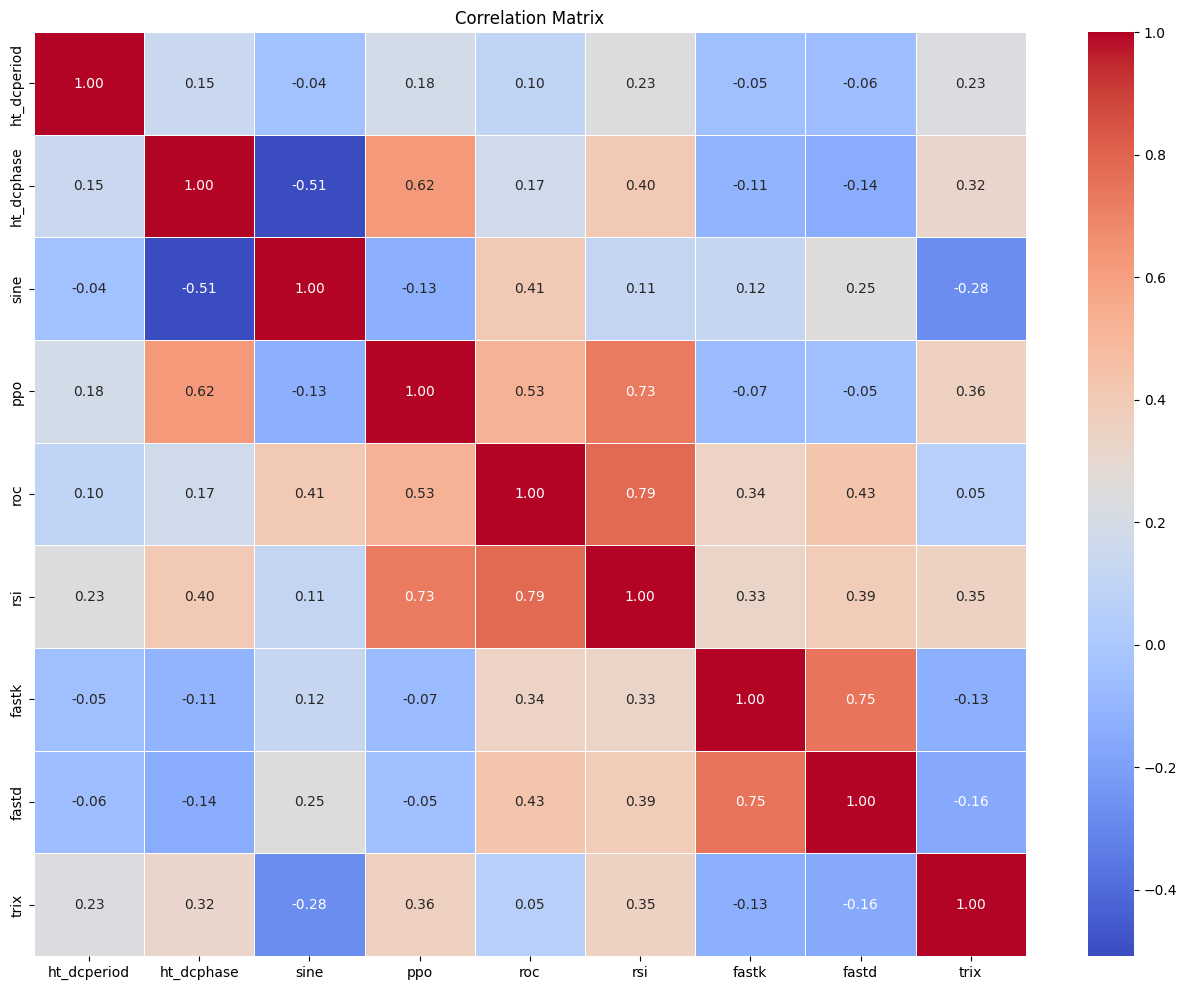

In [ ]:
# 선택된 변수 (0.8이상 상관관계 제거)
f_select = ['ht_dcperiod', 'ht_dcphase', 'sine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

hm = heatmap[f_select]

# 상관관계 행렬 계산
corr = hm.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 전처리

In [20]:
# 문자형인 종속 변수를 수치형으로 변환
df['label'] = df['label'].map({'up': 1, 'down': 0})

# 데이터 분할
df.index = pd.to_datetime(df.index)
idx = pd.Timestamp('2023-01-01')
train_data = df[df.index < idx]
test_data = df[df.index >= idx]

## 전체 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)


## 상관관계 < 0.8 변수 집합
f_select = ['ht_dcperiod', 'ht_dcphase', 'ht_trendmode', 'sine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x_fs = train_data[f_select]
train_y_fs = train_data['label']
test_x_fs = test_data[f_select]
test_y_fs = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_fs_scaled = scaler.fit_transform(train_x_fs)
test_x_fs_scaled = scaler.transform(test_x_fs)

# 1. Logistic Regression

In [21]:
# 모델 선언
lr = LogisticRegression(random_state=123)

# 모델 학습
lr.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = lr.predict(train_x_scaled)
y_pred = lr.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

# 혼동행렬 출력
print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 0.5307
test Accuracy: 0.5267
test performance 
               precision    recall  f1-score   support

           0       0.44      0.14      0.21       170
           1       0.54      0.85      0.66       204

    accuracy                           0.53       374
   macro avg       0.49      0.49      0.44       374
weighted avg       0.49      0.53      0.46       374



         Feature  Importance
0            cmo    0.065543
8            rsi    0.065543
2     ht_dcphase    0.050642
5   ht_trendmode    0.045212
4       leadsine    0.044248
10         fastd    0.035699
6            ppo    0.032795
3           sine    0.013485
1    ht_dcperiod   -0.012564
7            roc   -0.084643
11          trix   -0.106307
9          fastk   -0.111660


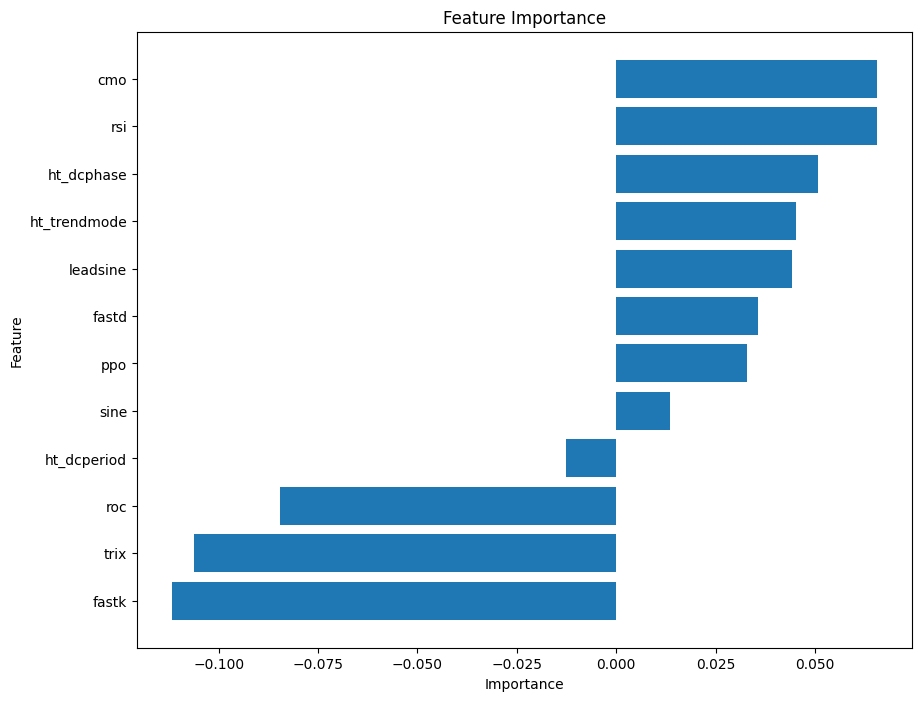

In [22]:
# 변수 중요도 출력
feature_importance = lr.coef_[0]
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [23]:
# 중요도가 양수인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0]['Feature']

# 양수 변수만을 사용한 새로운 데이터 준비
train_x_lr = train_x[positive_features]
test_x_lr = test_x[positive_features]

# 데이터 스케일링
train_x_lr = scaler.fit_transform(train_x_lr)
test_x_lr = scaler.transform(test_x_lr)

# 모델 선언 및 학습
lr_important_v = LogisticRegression(random_state=123)
lr_important_v.fit(train_x_lr, train_y)

train_pred_important_v = lr_important_v.predict(train_x_lr)
y_pred_important_v = lr_important_v.predict(test_x_lr)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_important_v)}")

train Accuracy: 0.5363
test Accuracy: 0.5615
test performance 
               precision    recall  f1-score   support

           0       0.57      0.14      0.22       170
           1       0.56      0.92      0.70       204

    accuracy                           0.56       374
   macro avg       0.57      0.53      0.46       374
weighted avg       0.57      0.56      0.48       374



In [24]:
# optuna를 활용하여 파라미터 최적화
def objective(trial):
    # Hyperparameter space
    tol = trial.suggest_float('tol', 1e-6, 1e-1, log=True)
    C = trial.suggest_float('C', 1e-5, 1, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = LogisticRegression(tol=tol, C=C, max_iter=max_iter, random_state=123)

    cv_scores = cross_val_score(model, train_x_lr, train_y, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    return mean_cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-16 14:43:06,174] A new study created in memory with name: no-name-cb7686e3-2df2-404e-8275-2e2abe02ef79
[I 2024-07-16 14:43:06,214] Trial 0 finished with value: 0.5187131126507569 and parameters: {'tol': 0.0002165494068665718, 'C': 0.07857157056449035, 'max_iter': 951}. Best is trial 0 with value: 0.5187131126507569.
[I 2024-07-16 14:43:06,245] Trial 1 finished with value: 0.525196732529296 and parameters: {'tol': 0.00017258090981009207, 'C': 5.0422527089027765e-05, 'max_iter': 680}. Best is trial 1 with value: 0.525196732529296.
[I 2024-07-16 14:43:06,267] Trial 2 finished with value: 0.5274987169617655 and parameters: {'tol': 0.0001478353381730242, 'C': 0.003643196877946432, 'max_iter': 786}. Best is trial 2 with value: 0.5274987169617655.
[I 2024-07-16 14:43:06,304] Trial 3 finished with value: 0.525196732529296 and parameters: {'tol': 2.8292456255662087e-06, 'C': 4.549533708108348e-05, 'max_iter': 952}. Best is trial 2 with value: 0.5274987169617655.
[I 2024-07-16 14:43:0

Best trial: 0.5298103241809939
Best parameters: {'tol': 1.8227332256777338e-05, 'C': 0.0034280704658995595, 'max_iter': 285}


In [25]:
best_params = study.best_params
lr_optuna = LogisticRegression(**best_params, random_state=123)
lr_optuna.fit(train_x_lr, train_y)

train_pred_optuna = lr_optuna.predict(train_x_lr)
y_pred_optuna = lr_optuna.predict(test_x_lr)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_optuna)}")

train Accuracy: 0.5307
test Accuracy: 0.5481
test performance 
               precision    recall  f1-score   support

           0       0.53      0.06      0.11       170
           1       0.55      0.96      0.70       204

    accuracy                           0.55       374
   macro avg       0.54      0.51      0.40       374
weighted avg       0.54      0.55      0.43       374



# 2. K-Nearest Neighbors (KNN)

In [26]:
# 모델 선언
knn = KNeighborsClassifier()

# 모델 학습
knn.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = knn.predict(train_x_scaled)
y_pred = knn.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

# 혼동행렬 출력
print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 0.6990
test Accuracy: 0.5107
test performance 
               precision    recall  f1-score   support

           0       0.46      0.46      0.46       170
           1       0.55      0.55      0.55       204

    accuracy                           0.51       374
   macro avg       0.51      0.51      0.51       374
weighted avg       0.51      0.51      0.51       374



In [27]:
# 상관 계수로 선택한 변수들로 모델 생성
knn.fit(train_x_fs_scaled, train_y)

train_pred_fs = knn.predict(train_x_fs_scaled)
y_pred_fs = knn.predict(test_x_fs_scaled)

train_accuracy_fs = accuracy_score(train_y, train_pred_fs)
accuracy_fs = accuracy_score(test_y, y_pred_fs)

print(f"train Accuracy: {train_accuracy_fs:.4f}")
print(f"test Accuracy: {accuracy_fs:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_fs)}")

train Accuracy: 0.6889
test Accuracy: 0.4813
test performance 
               precision    recall  f1-score   support

           0       0.43      0.44      0.43       170
           1       0.52      0.52      0.52       204

    accuracy                           0.48       374
   macro avg       0.48      0.48      0.48       374
weighted avg       0.48      0.48      0.48       374



In [28]:
# GridSearchCV를 사용하여 최적의 k 값 찾기 (전체 변수)
param_grid = {'n_neighbors': np.arange(1, 75)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y)

# 최적의 k 값
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 51


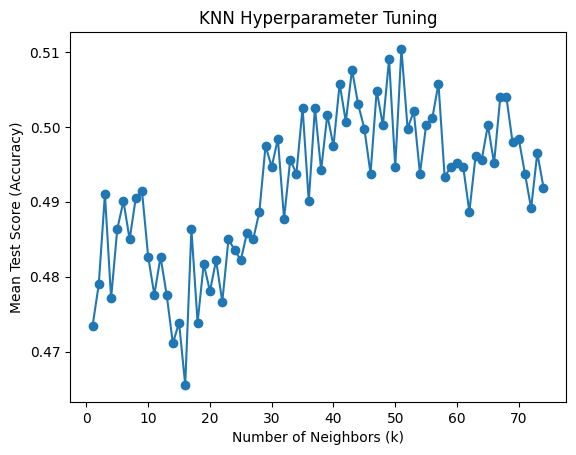

In [29]:
# 결과 시각화
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

plt.plot(param_grid['n_neighbors'], mean_test_scores, marker='o')
plt.title('KNN Hyperparameter Tuning')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score (Accuracy)')
plt.show()

In [30]:
# 파라미터 최적화 후 KNN 모델 생성
knn_bp = KNeighborsClassifier(n_neighbors = 51)

knn_bp.fit(train_x_scaled, train_y)

train_pred_bp = knn_bp.predict(train_x_scaled)
y_pred_bp = knn_bp.predict(test_x_scaled)

train_accuracy_bp = accuracy_score(train_y, train_pred_bp)
accuracy_bp = accuracy_score(test_y, y_pred_bp)

print(f"train Accuracy: {train_accuracy_bp:.4f}")
print(f"test Accuracy: {accuracy_bp:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_bp)}")

train Accuracy: 0.5529
test Accuracy: 0.4973
test performance 
               precision    recall  f1-score   support

           0       0.44      0.39      0.41       170
           1       0.54      0.59      0.56       204

    accuracy                           0.50       374
   macro avg       0.49      0.49      0.49       374
weighted avg       0.49      0.50      0.49       374



In [31]:
# GridSearchCV를 사용하여 최적의 k 값 찾기 (상관 계수 선택 변수)
param_grid = {'n_neighbors': np.arange(1, 75)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_fs_scaled, train_y)

# 최적의 k 값
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 65


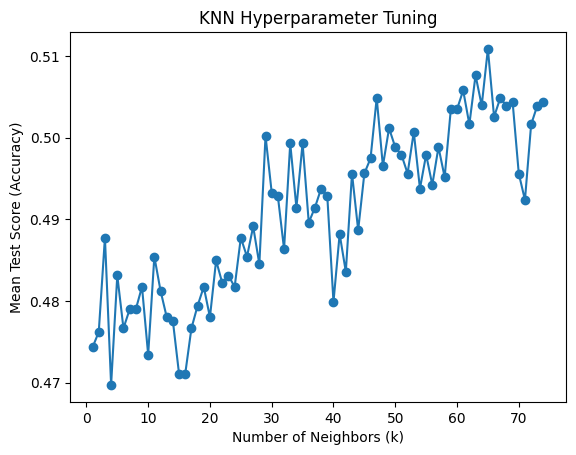

In [32]:
# 결과 시각화
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

plt.plot(param_grid['n_neighbors'], mean_test_scores, marker='o')
plt.title('KNN Hyperparameter Tuning')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score (Accuracy)')
plt.show()

In [33]:
# 파라미터 최적화 후 KNN 모델 생성
knn_bp = KNeighborsClassifier(n_neighbors = 65)

knn_bp.fit(train_x_fs_scaled, train_y)

train_pred_fs_bp = knn_bp.predict(train_x_fs_scaled)
y_pred_fs_bp = knn_bp.predict(test_x_fs_scaled)

train_accuracy_fs_bp = accuracy_score(train_y, train_pred_fs_bp)
accuracy_fs_bp = accuracy_score(test_y, y_pred_fs_bp)

print(f"train Accuracy: {train_accuracy_fs_bp:.4f}")
print(f"test Accuracy: {accuracy_fs_bp:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_fs_bp)}")

train Accuracy: 0.5562
test Accuracy: 0.5080
test performance 
               precision    recall  f1-score   support

           0       0.45      0.34      0.38       170
           1       0.54      0.65      0.59       204

    accuracy                           0.51       374
   macro avg       0.49      0.49      0.49       374
weighted avg       0.50      0.51      0.50       374



# 3. Naive Baise

In [34]:
# 모델 선언
nb = GaussianNB()

# 모델 학습
nb.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = nb.predict(train_x_scaled)
y_pred = nb.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

# 혼동행렬 출력
print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 0.5340
test Accuracy: 0.5267
test performance 
               precision    recall  f1-score   support

           0       0.47      0.28      0.35       170
           1       0.55      0.73      0.63       204

    accuracy                           0.53       374
   macro avg       0.51      0.51      0.49       374
weighted avg       0.51      0.53      0.50       374



In [35]:
# 상관 계수로 선택한 변수들로 모델 생성
nb.fit(train_x_fs_scaled, train_y)

train_pred_fs = nb.predict(train_x_fs_scaled)
y_pred_fs = nb.predict(test_x_fs_scaled)

train_accuracy_fs = accuracy_score(train_y, train_pred_fs)
accuracy_fs = accuracy_score(test_y, y_pred_fs)

print(f"train Accuracy: {train_accuracy_fs:.4f}")
print(f"test Accuracy: {accuracy_fs:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_fs)}")

train Accuracy: 0.5307
test Accuracy: 0.5401
test performance 
               precision    recall  f1-score   support

           0       0.49      0.26      0.34       170
           1       0.56      0.77      0.65       204

    accuracy                           0.54       374
   macro avg       0.52      0.52      0.49       374
weighted avg       0.53      0.54      0.51       374



In [36]:
# 상관 계수 변수 모델 optuna

def objective(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    
    model = GaussianNB(var_smoothing=var_smoothing)
    scores = cross_val_score(model, train_x_fs_scaled, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-16 14:43:43,343] A new study created in memory with name: no-name-0b289d6f-a2db-4590-97b7-f4295a5b95ba
[I 2024-07-16 14:43:43,360] Trial 0 finished with value: 0.5284396116670943 and parameters: {'var_smoothing': 1.3584500481627432e-11}. Best is trial 0 with value: 0.5284396116670943.
[I 2024-07-16 14:43:43,380] Trial 1 finished with value: 0.5284396116670943 and parameters: {'var_smoothing': 6.789619551318168e-11}. Best is trial 0 with value: 0.5284396116670943.
[I 2024-07-16 14:43:43,393] Trial 2 finished with value: 0.5284396116670943 and parameters: {'var_smoothing': 1.3610198970578982e-08}. Best is trial 0 with value: 0.5284396116670943.
[I 2024-07-16 14:43:43,423] Trial 3 finished with value: 0.5284396116670943 and parameters: {'var_smoothing': 1.642258002332793e-09}. Best is trial 0 with value: 0.5284396116670943.
[I 2024-07-16 14:43:43,438] Trial 4 finished with value: 0.5284396116670943 and parameters: {'var_smoothing': 1.0472610859058797e-10}. Best is trial 0 with 

Best trial: 0.5284396116670943
Best parameters: {'var_smoothing': 1.3584500481627432e-11}


In [37]:
best_params = study.best_params
nb_optuna = GaussianNB(**best_params)
nb_optuna.fit(train_x_fs_scaled, train_y)

train_pred_optuna = nb_optuna.predict(train_x_fs_scaled)
y_pred_optuna = nb_optuna.predict(test_x_fs_scaled)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_optuna)}")

train Accuracy: 0.5307
test Accuracy: 0.5401
test performance 
               precision    recall  f1-score   support

           0       0.49      0.26      0.34       170
           1       0.56      0.77      0.65       204

    accuracy                           0.54       374
   macro avg       0.52      0.52      0.49       374
weighted avg       0.53      0.54      0.51       374



# 4. Decision Tree

In [38]:
# 모델 선언
dt = DecisionTreeClassifier(random_state=123)

# 모델 학습
dt.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = dt.predict(train_x_scaled)
y_pred = dt.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 1.0000
test Accuracy: 0.4866
test performance 
               precision    recall  f1-score   support

           0       0.44      0.45      0.44       170
           1       0.53      0.52      0.52       204

    accuracy                           0.49       374
   macro avg       0.48      0.48      0.48       374
weighted avg       0.49      0.49      0.49       374



         Feature  Importance
1    ht_dcperiod    0.151874
6            ppo    0.141003
7            roc    0.133457
11          trix    0.116018
10         fastd    0.106353
2     ht_dcphase    0.075926
0            cmo    0.068540
9          fastk    0.061501
8            rsi    0.050883
4       leadsine    0.045799
3           sine    0.043404
5   ht_trendmode    0.005242


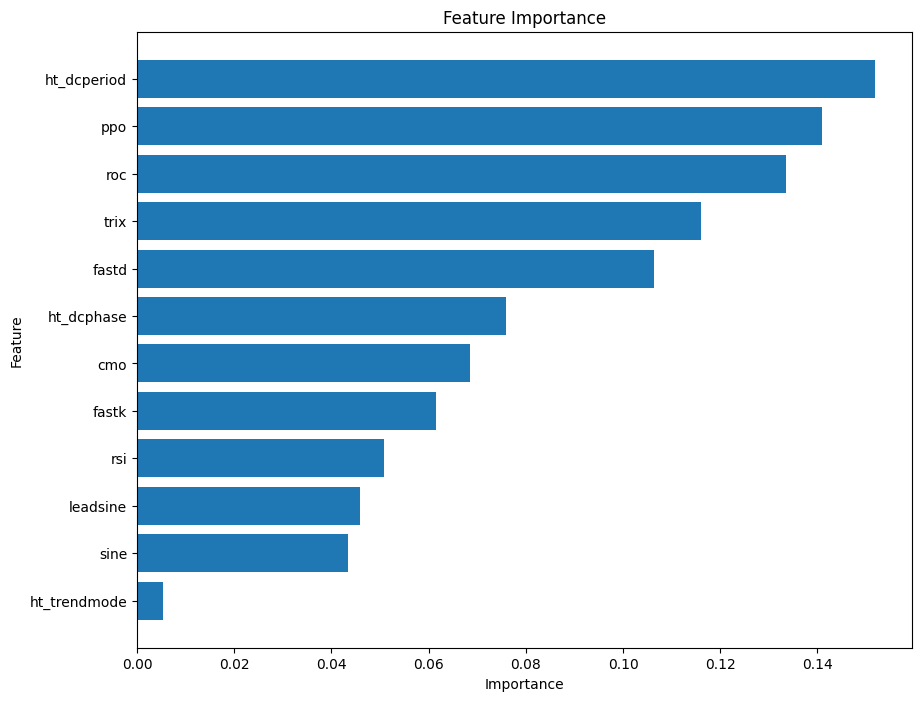

In [39]:
feature_importance = dt.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [40]:
# 중요도가 0.09 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.09]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_dt = train_x[positive_features]
test_x_dt = test_x[positive_features]

# 데이터 스케일링
train_x_dt = scaler.fit_transform(train_x_dt)
test_x_dt = scaler.transform(test_x_dt)

# 모델 선언 및 학습
dt_important_v = DecisionTreeClassifier(random_state=123)
dt_important_v.fit(train_x_dt, train_y)

train_pred_important_v = dt_important_v.predict(train_x_dt)
y_pred_important_v = dt_important_v.predict(test_x_dt)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_important_v)}")

train Accuracy: 1.0000
test Accuracy: 0.4786
test performance 
               precision    recall  f1-score   support

           0       0.43      0.46      0.44       170
           1       0.52      0.50      0.51       204

    accuracy                           0.48       374
   macro avg       0.48      0.48      0.48       374
weighted avg       0.48      0.48      0.48       374



In [41]:
# 변수 선택 모델 optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        random_state=123
    )
    
    scores = cross_val_score(model, train_x_dt, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-16 14:44:00,811] A new study created in memory with name: no-name-e21f7c7b-43a7-4c62-80d9-b79e0308d37d
[I 2024-07-16 14:44:00,838] Trial 0 finished with value: 0.5145774527414251 and parameters: {'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 13, 'min_weight_fraction_leaf': 0.213751811808144}. Best is trial 0 with value: 0.5145774527414251.
[I 2024-07-16 14:44:00,894] Trial 1 finished with value: 0.48592934736121807 and parameters: {'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 14, 'min_weight_fraction_leaf': 0.08536421547150974}. Best is trial 0 with value: 0.5145774527414251.
[I 2024-07-16 14:44:00,911] Trial 2 finished with value: 0.5108448806774442 and parameters: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 15, 'min_weight_fraction_leaf': 0.35725134281589804}. Best is trial 0 with value: 0.5145774527414251.
[I 2024-07-16 14:44:00,934] Trial 3 finished with value: 0.5108448806774442 and parameters: {'max_depth': 7, 'min_sam

Best trial: 0.5145774527414251
Best parameters: {'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 13, 'min_weight_fraction_leaf': 0.213751811808144}


In [42]:
best_params = study.best_params
dt_optuna = DecisionTreeClassifier(**best_params, random_state = 123)
dt_optuna.fit(train_x_dt, train_y)

train_pred_optuna = dt_optuna.predict(train_x_dt)
y_pred_optuna = dt_optuna.predict(test_x_dt)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_optuna)}")

train Accuracy: 0.5381
test Accuracy: 0.5187
test performance 
               precision    recall  f1-score   support

           0       0.45      0.24      0.31       170
           1       0.54      0.75      0.63       204

    accuracy                           0.52       374
   macro avg       0.49      0.50      0.47       374
weighted avg       0.50      0.52      0.49       374



# 5. Random Forest

In [43]:
# 모델 선언
rf = RandomForestClassifier(random_state=123)

# 모델 학습
rf.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = rf.predict(train_x_scaled)
y_pred = rf.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 1.0000
test Accuracy: 0.4866
test performance 
               precision    recall  f1-score   support

           0       0.44      0.44      0.44       170
           1       0.53      0.53      0.53       204

    accuracy                           0.49       374
   macro avg       0.48      0.48      0.48       374
weighted avg       0.49      0.49      0.49       374



         Feature  Importance
1    ht_dcperiod    0.102380
7            roc    0.101657
11          trix    0.097510
6            ppo    0.097499
0            cmo    0.092416
10         fastd    0.090847
8            rsi    0.089989
4       leadsine    0.089060
2     ht_dcphase    0.086529
3           sine    0.084441
9          fastk    0.061196
5   ht_trendmode    0.006476


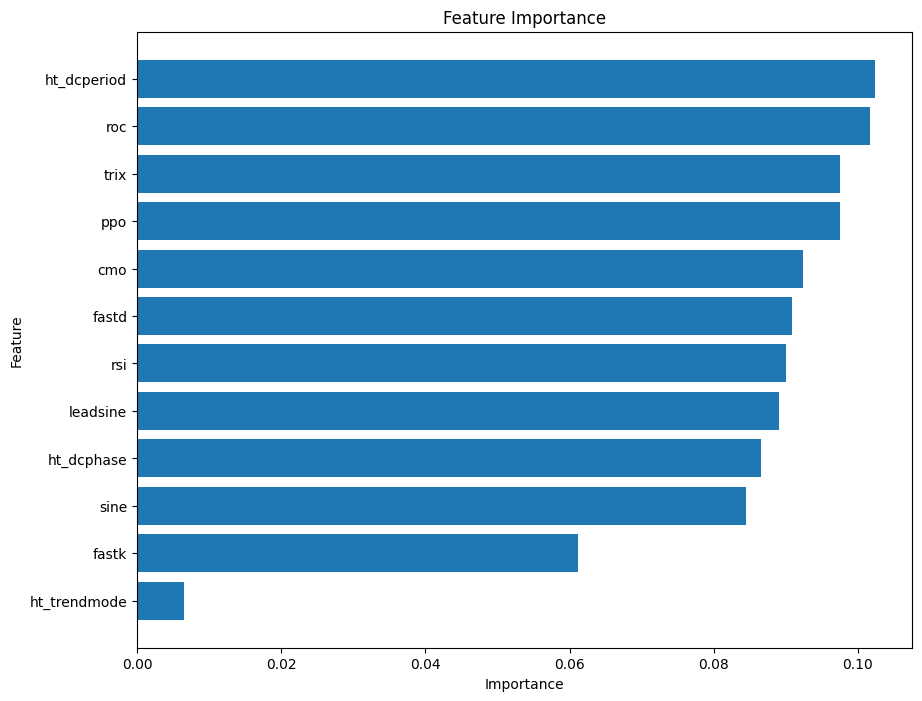

In [44]:
# 변수 중요도 계산
feature_importances = rf.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [45]:
# 중요도가 0.08 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.08]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_rf = train_x[positive_features]
test_x_rf = test_x[positive_features]

# 데이터 스케일링
train_x_rf = scaler.fit_transform(train_x_rf)
test_x_rf = scaler.transform(test_x_rf)

# 모델 선언 및 학습
rf_important_v = RandomForestClassifier(random_state=123)
rf_important_v.fit(train_x_rf, train_y)

train_pred_important_v = rf_important_v.predict(train_x_rf)
y_pred_important_v = rf_important_v.predict(test_x_rf)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_important_v)}")

train Accuracy: 1.0000
test Accuracy: 0.5080
test performance 
               precision    recall  f1-score   support

           0       0.46      0.54      0.50       170
           1       0.56      0.49      0.52       204

    accuracy                           0.51       374
   macro avg       0.51      0.51      0.51       374
weighted avg       0.51      0.51      0.51       374



In [46]:
# 변수 선택 모델 optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        random_state=123
    )
    
    scores = cross_val_score(model, train_x_rf, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-16 14:44:14,710] A new study created in memory with name: no-name-ba302575-0992-43b3-a5fe-2aea4812ce2a
[I 2024-07-16 14:44:17,396] Trial 0 finished with value: 0.49330254041570437 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 7, 'n_estimators': 79}. Best is trial 0 with value: 0.49330254041570437.
[I 2024-07-16 14:44:24,362] Trial 1 finished with value: 0.4854599692070824 and parameters: {'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 19, 'n_estimators': 282}. Best is trial 0 with value: 0.49330254041570437.
[I 2024-07-16 14:44:27,003] Trial 2 finished with value: 0.49146031135061163 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 7, 'n_estimators': 89}. Best is trial 0 with value: 0.49330254041570437.
[I 2024-07-16 14:44:29,055] Trial 3 finished with value: 0.4886964331537079 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 16, 'n_estimators': 82}. Best is trial 0 with

In [ ]:
best_params = study.best_params
rf_optuna = RandomForestClassifier(**best_params, random_state = 123)
rf_optuna.fit(train_x_rf, train_y)

train_pred_optuna = rf_optuna.predict(train_x_rf)
y_pred_optuna = rf_optuna.predict(test_x_rf)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_optuna)}")

train Accuracy: 0.5497
test Accuracy: 0.5481
test performance 
               precision    recall  f1-score   support

           0       0.53      0.05      0.09       170
           1       0.55      0.97      0.70       204

    accuracy                           0.55       374
   macro avg       0.54      0.51      0.39       374
weighted avg       0.54      0.55      0.42       374



# 6. XGboost

In [ ]:
# XGB 모델 생성
xg = xgb.XGBClassifier(random_state=123)

# 모델 학습
xg.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = xg.predict(train_x_scaled)
y_pred = xg.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

# 혼동행렬 출력
print(f"test performance \n {classification_report(test_y, y_pred)}")

train Accuracy: 0.9977
test Accuracy: 0.4893
test performance 
               precision    recall  f1-score   support

           0       0.44      0.46      0.45       170
           1       0.53      0.51      0.52       204

    accuracy                           0.49       374
   macro avg       0.49      0.49      0.49       374
weighted avg       0.49      0.49      0.49       374



         Feature  Importance
4       leadsine    0.109574
6            ppo    0.099676
2     ht_dcphase    0.097890
9          fastk    0.094651
7            roc    0.093732
1    ht_dcperiod    0.092429
0            cmo    0.088293
10         fastd    0.087983
11          trix    0.084459
3           sine    0.081430
5   ht_trendmode    0.069882
8            rsi    0.000000


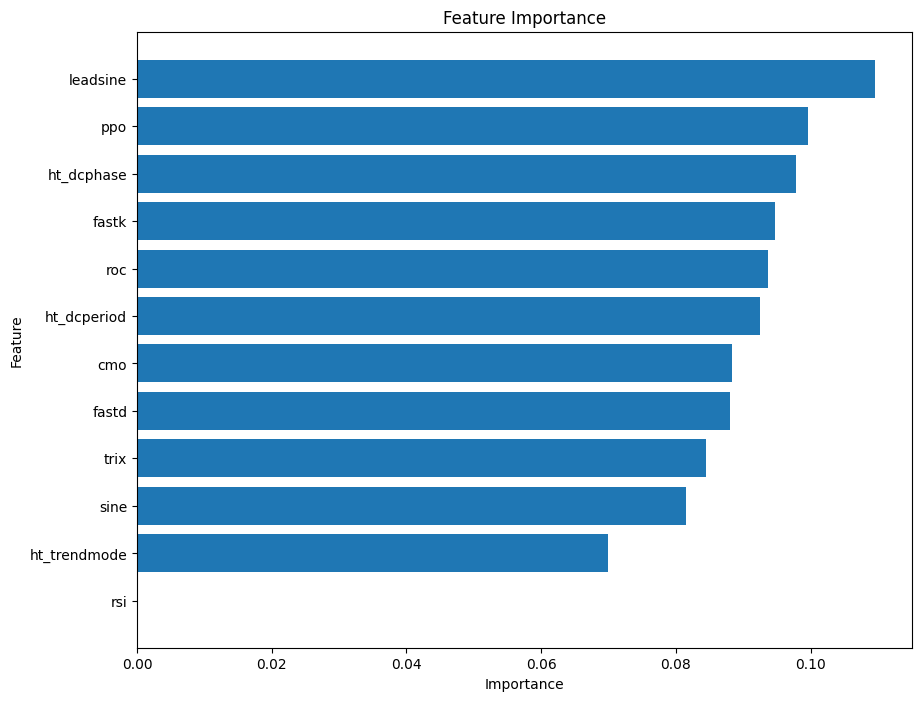

In [ ]:
# 변수 중요도 계산
feature_importances = xg.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 중요도가 0.09 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.09]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_xg = train_x[positive_features]
test_x_xg = test_x[positive_features]

# 데이터 스케일링
train_x_xg = scaler.fit_transform(train_x_xg)
test_x_xg = scaler.transform(test_x_xg)

# 모델 선언 및 학습
xg_important_v = xgb.XGBClassifier(random_state=123)
xg_important_v.fit(train_x_xg, train_y)

train_pred_important_v = xg_important_v.predict(train_x_xg)
y_pred_important_v = xg_important_v.predict(test_x_xg)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_important_v)}")

train Accuracy: 0.9898
test Accuracy: 0.4973
test performance 
               precision    recall  f1-score   support

           0       0.45      0.46      0.45       170
           1       0.54      0.53      0.53       204

    accuracy                           0.50       374
   macro avg       0.49      0.49      0.49       374
weighted avg       0.50      0.50      0.50       374



In [ ]:
# 선택 변수 모델로 optuna

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    model = xgb.XGBClassifier(**param, random_state=123)
    scores = cross_val_score(model, train_x_xg, train_y, cv=5, scoring='accuracy')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-15 14:54:22,459] A new study created in memory with name: no-name-e0e21f25-6c1a-4208-b91f-4063d04abbb1
[I 2024-07-15 14:54:23,136] Trial 0 finished with value: 0.5145688991531948 and parameters: {'max_depth': 7, 'learning_rate': 0.0030613847568198953, 'n_estimators': 394, 'subsample': 0.8938868699895226, 'colsample_bytree': 0.5416707593730441, 'gamma': 2.370774010244083, 'reg_alpha': 1.7607429769443033, 'reg_lambda': 4.7567383479984455}. Best is trial 0 with value: 0.5145688991531948.
[I 2024-07-15 14:54:25,772] Trial 1 finished with value: 0.513184287058421 and parameters: {'max_depth': 10, 'learning_rate': 0.0014569614765621401, 'n_estimators': 492, 'subsample': 0.763069482685711, 'colsample_bytree': 0.7549873582663895, 'gamma': 1.3614480766685777, 'reg_alpha': 0.3124154861246009, 'reg_lambda': 0.11043990726177455}. Best is trial 0 with value: 0.5145688991531948.
[I 2024-07-15 14:54:26,585] Trial 2 finished with value: 0.5117932597724746 and parameters: {'max_depth': 5, 'l

Best trial: 0.5279713027114875
Best parameters: {'max_depth': 5, 'learning_rate': 0.008830341485383223, 'n_estimators': 139, 'subsample': 0.9384337992532084, 'colsample_bytree': 0.629207653847931, 'gamma': 2.914780375664383, 'reg_alpha': 1.7444684697782373, 'reg_lambda': 1.1933858441925127}


In [ ]:
best_params = study.best_params
xg_optuna = xgb.XGBClassifier(**best_params, random_state=123)
xg_optuna.fit(train_x_xg, train_y)
 
train_pred_optuna = xg_optuna.predict(train_x_xg)
y_pred_optuna = xg_optuna.predict(test_x_xg)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

print(f"test performance \n {classification_report(test_y, y_pred_optuna)}")

train Accuracy: 0.5867
test Accuracy: 0.5455
test performance 
               precision    recall  f1-score   support

           0       0.50      0.14      0.21       170
           1       0.55      0.89      0.68       204

    accuracy                           0.55       374
   macro avg       0.53      0.51      0.45       374
weighted avg       0.53      0.55      0.47       374

